# _**HDBSCAN**_   

__Как работает HDBSCAN__  

__1. Расчет весов ребер для будущего графа - это взвешенный граф с рёбрами, где вес — это расстояние между точками.__  

   >__1.1. Как определяется вес.__   
      >>__1.1.1. Производится расчет "ядерного" расстояния.__   
      Как. Для каждой точки определяется ее k-дальний сосед, то есть та точка, которая занимает k-е место в упорядоченном по расстоянию списке компонентов соседей. В HDBSCAN `к-дальний сосед` — это параметр `min_samples`.  
      >>__1.1.2. Преобразование расстояний (Mutual Reachability Distance, M-RD).__  
      <small>например, для 2-х точек - А и Б.  
      `М-РД(А,Б)=макс ( ядро-расст(A),ядро-расст(B),расст(А,Б) )`  
      где:  
      - `ядро-расст(A)` — это "ядровое" расстояние от А до ее `min_samples` - дальнего соседа (это мера плотности вокруг точек),  
      - `ядро-расст(B)` — аналогично для Б,  
      - `расст(А,Б)` — обычное расстояние между А и Б(например, Евклидово).  
      Как интерпретировать эту формулу.
      - если А и Б находятся в плотной области (у них `к-дальний сосед` находится на небольшом расстоянии (что говорит о плотном скоплении точек), то расстояние между ними будет небольшим , и тогда M-RD совпадёт с расст(А,Б) (евклидово).
      - если хотя бы одна из точек будет находится в разреженной области (т. е. `к-дальний сосед` у нее находится на большом расстоянии (большое "ядровое" растояние), и если А и В находятся на большом расстоянии друг от друга, то M-RD примет большее значение из них.  
      Например: ядро-расст(A) = 1.2, ядро-расст(B) = 2.0  
      Обычное расстояние между ними: раст(А,Б)=1.5  
      Тогда: М-РД(А,Б)=макс (1.2,2.0,1.5) = 2.0</small>

__2. Строительство минимального остовного дерева (MST)__  
  >__2.1. Строится граф, где вершины — это точки, а рёбра — это расстояние взаимной достижимости (M-RD) между ними.__  
  Находится минимальное остовое дерево (MST) — подграф, который соединяет все точки с минимальной суммой весов (применяя алгоритм Прима или Крускала).  
  MST содержит только ( Н−1)рёбер для Н точек.  

  >__2.2. Разбиение MST на кластеры.__  
  📌 Идея: В MST разрываем «самые длинные» рёбра, чтобы разделить группы точек, так что длинные рёбра (с большим значением M-RD) обозначают границы между плотными областями.  
  Удаление таких рёбер разделяет дерево на поддеревья , которые образуют кластеры.  
  >__2.3. Создание «конденсированного дерева» (Condensed Tree)__  
  HDBSCAN строит иерархическое представление кластеров , анализируя, как изменять кластеры при разных уровнях плотности. Находится оптимальное разбиение с максимальной устойчивостью кластеров. Используемый параметр `min_cluster_size`, чтобы оставить только достаточно крупные кластеры.  

__3. Точки, которые не попали в кластеры, отличаются шумом (выбросами).__

__Итого:__  
- может обрабатывать кластеры с разной плотностью  
- меньше зависимости от выбора параметра eps, как в DBSCAN  
- не требует заранее заданного числа кластеров (в отличие от KMeans)  
- может эффективно работать с шумом (кластеризует шум как отдельные точки)  

__Параметры HDBSCAN:__  
- _min_samples_: минимальное количество точек в окрестности, чтобы считаться ядром кластера. Чем больше это значение, тем меньше будет кластеров, и больше — шум.  
- _min_cluster_size_: минимальный размер кластера. Устанавливает, сколько точек должно быть в одном кластере для его определения.  
- _metric_: метрика расстояния (по умолчанию используется euclidean, что  подходит для эмбеддингов, если они нормализованы).  

# <font color='yellow'>->_pip, import_

#### <font color='yellow'>_Импорты_

In [ ]:
!pip install transformers[sentencepiece]
!pip install -U sentence-transformers
!pip install huggingface_hub
!pip install tqdm
!pip install hdbscan

In [2]:
import torch
from sentence_transformers import SentenceTransformer

In [3]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Кластеризатор
import hdbscan

#### <font color='yellow'>_Работа локально_

In [ ]:
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv
# Проверка
load_dotenv()
print(os.getenv("HF_TOKEN"))

# Использования токена:
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

In [ ]:
# Подключение файла classifiers_functions.py (классификаторы и ф-ция оценки качества классификации)
sys.path.append('./Classifiers')
import classifiers_functions

#### <font color='yellow'>_Работа на Google Colab_

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
## Связь с Google drıve (для связи с файлами данных на google drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='lightblue'>-> _кластеризация по сохраненным эмбеддингам_

### _загрузка текстов и их эмбеддингов <font color='orange'><small>(all_texts, ebeddings)_  

In [ ]:
# Если не было ранее подключение в google drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Загрузка текстов

# _______ Параметры ______________
chunk_size = 1000 # # Размер чанка при загрузке текстов
# Google Colab
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'
# Локально
# file_path_data = 'articles.csv'
text_column = "title"  # Название колонки с текстами

# _________ Загрузка _______________________

all_texts = []
max_text = 5000 # maximum number of texts !!! Используется в названии файла !!!
current_count = 0

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):
    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]
    all_texts.extend(texts)  # Объединяем части текста вместе

    current_count += len(texts)
    if current_count >= max_text:
        break

len(all_texts) # list

Обработка данных: 4it [00:00, 14.75it/s]


5000

In [7]:
# Загрузка эмбеддингов

# _________ Параметры ____________
batch_size = 1000  # Размер батча

# Google Colab
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу эмбеддингов
# Локально
# file_path_embeddings = './Data/embeddings_rubert-tiny2.npy'  # Файл с эмбеддингами

# _________ Загрузка _______________________
# Загружаем файл в режиме "чтение без загрузки в память"
embeddings_mmap = np.load(file_path_embeddings, mmap_mode="r")

num_samples = embeddings_mmap.shape[0] # Определяем количество примеров (должно быть = max_text)
all_embeddings = [] # Пустой список для хранения частей эмбеддингов

# Читаем файл частями
for i in range(0, num_samples, batch_size):
    batch = embeddings_mmap[i : i + batch_size]  # Загружаем батч
    all_embeddings.append(batch)  # Добавляем в список

embeddings = np.vstack(all_embeddings) # Объединяем все части в один массив NumPy

print(f"Форма объединённого массива: {embeddings.shape}") # Проверяем размер итогового массива

Форма объединённого массива: (5000, 312)


### _анализ данных_ <font color='orange'><small>(дендрограмма, среднее расстояние между точками, проверка эмбеддингов (нормализация)</small>).

In [ ]:
# _________Построением дендрограммы_________
# 📌 Позволяет прикинуть, на сколько классов целесообразно разбить данные.
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(embeddings[:100], method='average', metric='cosine'))

# Добавляем горизонтальную линию на уровне ...
plt.axhline(y=0.26, color='r', linestyle='--')  # Порог для разбиения

plt.show()

In [ ]:
# _________Среднее расстояние между точками.___________
# 📌 Для DBSCAN это дает ориентир для выбора значения `eps` - параметра окна, в котором подсчитывается число "соседних" точек.
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5) #  ищем 5 ближайших соседей для каждой точки.
neighbors.fit(embeddings)                   #  "запоминаем" точки эмбеддингов в алгоритме ближайших соседей.
#  вычисляем расстояния до n_neighbors ближайших точек.
distances, _ = neighbors.kneighbors(embeddings)
avg_distance = np.mean(distances[:, -1])  # Среднее расстояние до 5-го соседа
print(f"Среднее расстояние между точками: {avg_distance:.4f}")
# Среднее расстояние между точками: 0.4798

Что делает `distances, _ = neighbors.kneighbors(embeddings)`  
В distances[i, j] хранится расстояние от i-го эмбеддинга текста до его j-го ближайшего соседа.  
Пример: distances[:]  
```
array([
    [0.00, 0.32, 0.45, 0.51, 0.67],  # 5 соседей для 1-го эмбеддинга текста
    [0.00, 0.28, 0.41, 0.55, 0.70],  # 5 соседей для 2-го эмбеддингатекста
    ...
    [0.00, 0.30, 0.49, 0.60, 0.80]   # 5 соседей для 27000-го эмбеддинга текста
])
```
distances[i, -1] — расстояние до самого дальнего из 5 соседей.

In [ ]:
# Нормализация эмбеддингов (проверка)
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

Min norm: 0.9999998211860657
Max norm: 1.0000001192092896
Mean norm: 1.0


### _кластеризация_

In [8]:
# Количественное распределение текстов по кластерам:
from collections import Counter

In [23]:
hdb = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=3, cluster_selection_epsilon=0.01, metric='euclidean')
# Получаем метки кластеров
clusters = hdb.fit_predict(embeddings)
# Количество кластеров и шума
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
num_noise = np.sum(clusters == -1)

print(f"Количество кластеров: {num_clusters}")
print(f"Шум (количество точек, отнесенных к шуму): {num_noise}")
counts_cluster = Counter(clusters) # Количественное распределение текстов по кластерам:
counts_cluster

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Количество кластеров: 4
Шум (количество точек, отнесенных к шуму): 2026


Counter({np.int64(-1): 2026,
         np.int64(0): 2174,
         np.int64(2): 787,
         np.int64(3): 6,
         np.int64(1): 7})

In [24]:
# Формируем датафрейм их текстов, их эмбеддингов и меток
df = pd.DataFrame({"text": all_texts, "embedding": list(embeddings), "cluster": list(clusters)})
df.head()

,text,embedding,cluster
0,Заместитель председателяnправительства РФnСерг...,"[0.07518719, -0.0055617844, 0.014240301, -0.04...",-1
1,Матч 1/16 финала Кубка России по футболу был п...,"[0.00035189706, -0.04810312, -0.020328153, -0....",-1
2,Форвард «Авангарда» Томаш Заборский прокоммент...,"[0.04424202, 0.00478189, -0.02290487, -0.04921...",0
3,Главный тренер «Кубани» Юрий Красножан прокомм...,"[0.047330584, 0.031060353, 0.0015447184, -0.03...",0
4,Решением попечительского совета владивостокско...,"[0.07092083, -0.05181958, -0.01780495, -0.0265...",-1


In [26]:
# Просмотр релевантности текстов в кластерах определенным темам
claster_number = 3 # Выбор номера кластера
df_filtered =  df[df["cluster"] == claster_number] # Фильтруем строки
print(df_filtered['text'].tail(10)) # Выводим первые 10 строк

3418    Папа римский Франциск в Сиктинской капелле отс...
4102    Папа римский Бенедикт XVI объяснил свое решени...
4103    Старший брат папы римского Бенедикта XVI заяви...
4110    Папа римский Бенедикт XVI, заявивший о своем о...
4155    Во время последней мессы папы римского Бенедик...
4346    В Ватикане подтвердили, что отрекшийся от прес...
Name: text, dtype: object


### _сохранение (тексты, эмбеддинги, метки)_

In [27]:
# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_HDBSCAN_{max_text}.csv'
# Локально
# output_file = f"./Data/clusters_rubert-tiny2_KMeans_{max_text}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_HDBSCAN_5000.csv.


## <font color='lightgreen'>_-> Визуализация кластеров_</font>

In [28]:
# Признаки (эмбеддинги)
X_old = np.stack(df['embedding'].to_numpy()) # Преобразуем списка с эмбеддингами в массив чисел
# Метки
y_old = df['cluster']

print(X_old.shape, X_old.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_old.shape, y_old.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float32
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


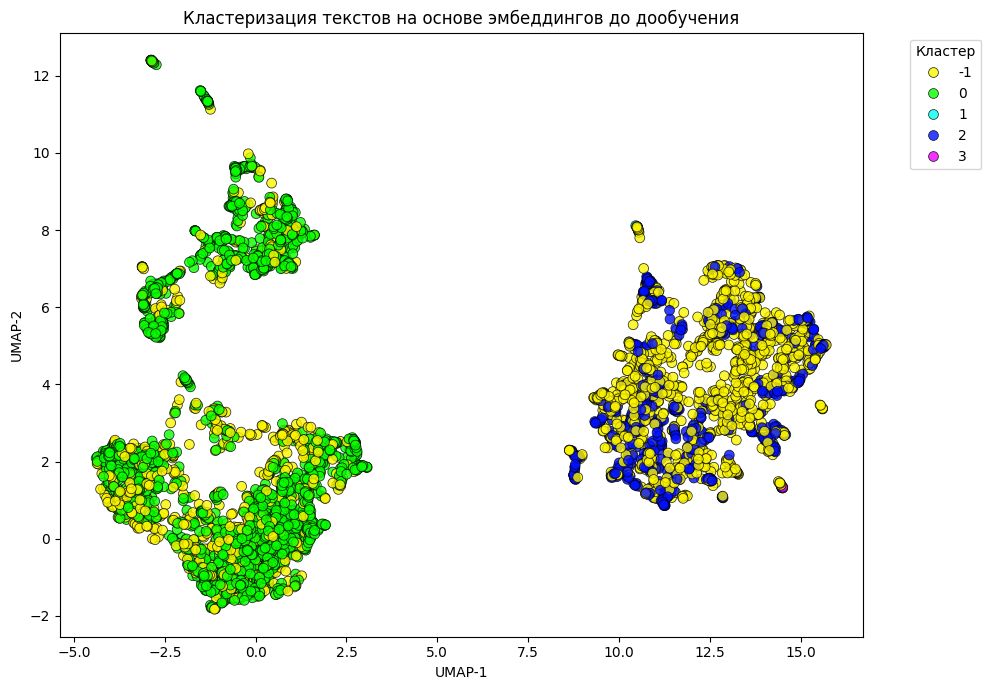

In [29]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_old)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_old
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_old)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов до дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## <font color='lightgreen'>_-> классификация:_</font>  
- <font color='orange'>LogisticRegression, KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier</font>

In [ ]:
# LogisticRegression
classifiers_functions.log_regression(X_train, y_train, X_test, y_test)

In [ ]:
# KNeighborsClassifier
classifiers_functions.knn(X_train, y_train, X_test, y_test)

In [ ]:
# SVC
classifiers_functions.svc(X_train, y_train, X_test, y_test)

In [ ]:
# DecisionTreeClassifier
classifiers_functions.decision_trees(X_train, y_train, X_test, y_test)

In [ ]:
# RandomForestClassifier
classifiers_functions.random_forest(X_train, y_train, X_test, y_test)


In [ ]:
# AdaBoostClassifier
classifiers_functions.ada_boosting(X_train, y_train, X_test, y_test)

In [ ]:
# GradientBoostingClassifier
classifiers_functions.grad_bosting(X_train, y_train, X_test, y_test)